In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import sys, os, time, collections

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'cells'))
# sys.path.append(os.path.join(os.environ['REPO_DIR'], 'annotation'))
# sys.path.append(os.path.join(os.environ['REPO_DIR']bb, 'learning'))

import numpy as np
import scipy
import skimage
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from skimage.measure import regionprops, label, find_contours
from skimage.color import rgb2hsv
from scipy import ndimage as ndi
import pandas
from scipy.signal import argrelmax
from scipy.stats import linregress

from annotation_utilities import *
from registration_utilities import *
from learning_utilities import *
from data_manager import *
from utilities2015 import *
from cell_utilities import *
from metadata import *
from distributed_utilities import download_from_s3

save_folder_path = '/shared/MouseBrainAtlasXiang/XJ/Output/Collect_typical_blobs/'
from xj_utilities import *
fun_create_folder(save_folder_path=save_folder_path)

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
No vtk


Setting environment for AWS compute node


Cannot import mxnet.
Folder already exists: /shared/MouseBrainAtlasXiang/XJ/Output/Collect_typical_blobs/

In [2]:
scan_parameters = {}

In [3]:
scan_parameters['stack'] = 'MD589'
scan_parameters['patch_size'] = 448
scan_parameters['patch_half_size'] = scan_parameters['patch_size']/2
scan_parameters['stride'] = 112

scan_parameters['section_limits'] = metadata_cache['section_limits'][scan_parameters['stack']]
scan_parameters['o_crop'] = True
scan_parameters['o_clear_border'] = True
scan_parameters['o_relabel'] = True
scan_parameters['oriImL1'], scan_parameters['oriImL0'] = metadata_cache['image_shape'][scan_parameters['stack']]
scan_parameters['scan_section_range'] = 1

scan_parameters['prop'] = ['centroid','eccentricity','area','orientation','moments_hu','bbox','equivalent_diameter','perimeter','compactness','label','major_axis_length','minor_axis_length']
scan_parameters['prop_for_comparison'] = ['area', 'eccentricity']
if 'moments_hu' in scan_parameters['prop_for_comparison']:
    scan_parameters['compare_weight'] = [1 for i in range(6 + len(scan_parameters['prop_for_comparison']))]
else:
    scan_parameters['compare_weight'] = [1 for i in range(len(scan_parameters['prop_for_comparison']))]
scan_parameters['compare_weight'] = np.array(scan_parameters['compare_weight'])/ float(np.sum(scan_parameters['compare_weight']))
scan_parameters['similarity_threshold'] = 0.8
scan_parameters['o_fix_scan_size'] = True
scan_parameters['scan_size'] = 112
scan_parameters['scan_size_coeff'] = 5
scan_parameters['builtInProps'] = ['centroid','orientation', 'eccentricity','area','orientation','moments_hu','bbox','equivalent_diameter','label','local_centroid','major_axis_length','solidity','minor_axis_length','perimeter','solidity']
scan_parameters['prop_to_save'] = ['coords','moments_hu','centroid','area','eccentricity','equivalent_diameter']

stack = scan_parameters['stack']

In [4]:
contour_df = DataManager.load_annotation_v4(stack=scan_parameters['stack'],by_human=True,suffix='contours',timestamp='latest')
contour_df = convert_annotation_v3_original_to_aligned_cropped(contour_df=contour_df,stack=stack)
structure_name = '7N'
vertice_7N_dic = {record['section']:np.array(record['vertices'],np.int) for _, record in contour_df[contour_df['name']==structure_name].iterrows()}
sectionList_7N = np.sort(vertice_7N_dic.keys())

aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/MD589" "/shared/CSHL_labelings_v3/MD589" --exclude "*" --include "*contours*"
latest timestamp:  07292017045157


In [5]:
margin = 10
bboxs_7N = {sec:fun_polygon_bbox(vertice_7N_dic[sec]) for sec in sectionList_7N}
bbox_7N = fun_polygons_bbox(bboxs_7N.values(),margin=margin)
scan_parameters['crop_range_mmxx'] = bbox_7N
scan_parameters['crop_0_min'], scan_parameters['crop_1_min'],scan_parameters['crop_0_max'],scan_parameters['crop_1_max'] = bbox_7N 
scan_parameters['im0max'] = scan_parameters['crop_0_max'] - scan_parameters['crop_0_min']
scan_parameters['im1max'] = scan_parameters['crop_1_max'] - scan_parameters['crop_1_min']
scan_parameters['crop_range_mxmx'] = fun_mmxx_to_mxmx(*scan_parameters['crop_range_mmxx'])

In [6]:
# loading data
image = {}
stack = scan_parameters['stack']
section_begin, section_end = scan_parameters['section_limits']
# secList = range(section_begin, section_end+1)
# tempSecList = range(section_begin, section_end+1)
secList = list(sectionList_7N[0:10])
tempSecList = list(sectionList_7N[0:10])
for tempSec in tempSecList:
    try:
        image[tempSec] = fun_crop_images(DataManager.load_image_v2(stack=stack, section=tempSec, version='jpeg', prep_id=2),*scan_parameters['crop_range_mmxx'],im0max=scan_parameters['oriImL0'],im1max=scan_parameters['oriImL1'] )
    except:
        sys.stderr.write('Invalid section %d...\n'%tempSec)
        secList.remove(tempSec)
        continue
#     if os.path.isfile(img_filename[tempSec]):
#         sys.stderr.write('Image file is already available. \n')
#         continue
#     else:
#         try:
#             download_from_s3(img_filename[tempSec])
#         except:
#             sys.stderr.write('Download fail. Skip this file for section %d...\n'%tempSec)
#             secList.remove(tempSec)
#             continue   
scan_parameters['secList'] = secList

/usr/local/lib/python2.7/dist-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (185246720 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


In [7]:
section = 153
scan_section_range = 1
sec_load_data_list = range(section - scan_section_range, section + scan_section_range + 1)
scan_section = list(sec_load_data_list)
scan_section.remove(section)
secList = scan_parameters['secList']
stack = scan_parameters['stack']

In [110]:
cell_centroids = {}
cell_numbers = {}
cell_global_coord = {}
im_blob_prop = {}
im_label_ori = {}
im_label = {}
im_BW = {}
for tempSec in sec_load_data_list:
    if tempSec in secList:
        cell_global_coord[tempSec] = load_cell_data('coords', stack=stack, sec=tempSec)
        temp_im_label, temp_im_blob_prop, _ = fun_reconstruct_labeled_image(cell_global_coord[tempSec],crop_range= scan_parameters['crop_range_mxmx'], 
                                                                    oriImL0=scan_parameters['oriImL0'],oriImL1=scan_parameters['oriImL1'])
        im_label[tempSec] = temp_im_label
        im_BW[tempSec] = temp_im_label > 0
        im_blob_prop[tempSec] = np.array(temp_im_blob_prop)
    else:
        sys.stderr.write('Warning: missing section %d'%tempSec)
        scan_section.remove(tempSec)

blob_prop_dic = fun_regionprops_dic(im_blob_prop=im_blob_prop,scan_parameters=scan_parameters)
blob_idx_selection = {tempSec : np.logical_and.reduce(np.row_stack(
    (blob_prop_dic[tempSec]['compactness']>0,
#      blob_prop_dic[tempSec]['compactness']<2.5,
     blob_prop_dic[tempSec]['area']<3000,
     blob_prop_dic[tempSec]['area']>200))) for tempSec in sec_load_data_list}

In [111]:
typical_blobs = []
matched_paris = []
scan_range = scan_parameters['scan_section_range']
scan_section = range(section - scan_range, section + scan_range + 1)
scan_section.remove(section)
im0max = scan_parameters['im0max']
im1max = scan_parameters['im1max']

prop = scan_parameters['prop']
prop_for_comparison = scan_parameters['prop_for_comparison']

compare_weight = scan_parameters['compare_weight']
o_simil_threshold = scan_parameters['similarity_threshold']
n_blobs = {tempSec: len(im_blob_prop[tempSec]) for tempSec in im_blob_prop.keys()}
o_fix_scan_size = scan_parameters['o_fix_scan_size']
o_scan_size_coeff = scan_parameters['scan_size_coeff']
o_scan_size = scan_parameters['scan_size']  
secList_in_BlobPropDic = im_blob_prop.keys()

In [112]:
if set(scan_section).issubset(set(secList_in_BlobPropDic)):
    pass
else:
    print('Warrning: Scaned section(s) not included in input im_blob_prop')

for blobID in range(n_blobs[section]):
    if (blobID % 1000 == 0):
        print('Section %d Finished percentage: %f'%(section, (float(blobID)*100 / n_blobs[section]) ))
    
    temp_curr_blob_props = {}
    for tempProp in prop:
        temp_curr_blob_props[tempProp] = blob_prop_dic[section][tempProp][blobID]
#         if tempProp in scan_parameters['builtInProps']:
#             temp_curr_blob_props[tempProp] = im_blob_prop[section][blobID][tempProp]
#         elif tempProp == 'compactness':
#             temp_curr_blob_props[tempProp] = im_blob_prop[section][blobID]['perimeter']**2/(4*PI*im_blob_prop[section][blobID]['area'])
    
    if not blob_idx_selection[section][blobID]:
#         print('Blob %d eliminated'%blobID)
        continue
    
    
    
    tempB1_idx_loc = temp_curr_blob_props['centroid']
    if o_fix_scan_size:
        temp_next_sec_range, local_cloc = fun_scan_range(tempB1_idx_loc,o_scan_size,im0max=im0max,im1max=im1max,o_form='2D')
        temp_next_sec_range_1D,_ = fun_scan_range(tempB1_idx_loc,o_scan_size,im0max=im0max,im1max=im1max)
    else:
        temp_next_sec_range, local_cloc = fun_scan_range(tempB1_idx_loc,o_scan_size_coeff*fun_radius_bbox(*temp_curr_blob_props.bbox),im0max=im0max,im1max=im1max,o_form='2D')
        temp_next_sec_range_1D,_ = fun_scan_range(tempB1_idx_loc,o_scan_size_coeff*fun_radius_bbox(*temp_curr_blob_props.bbox),im0max=im0max,im1max=im1max)


    for tempSec in scan_section:
#         print('Blbo %d left. Start scanning'%blobID)
        if tempSec not in secList_in_BlobPropDic:
            continue

        # Find blobs at the nearby location in the scaned section
        # Method 1
        tempPath = matplotlib.path.Path(temp_next_sec_range)
        tempBlobInside = tempPath.contains_points(blob_prop_dic[tempSec]['centroid'])
#         tempBlobInside = tempPath.contains_points(blobs_centroids_dic[tempSec])
#         tempBlobInsideIndex = blobs_idx_dic[tempSec][tempBlobInside]
        tempBlobInsideIndex = np.where(tempBlobInside)[0]
        # Method 2
#            temp_im = fun_crop_images(im_label[tempSec],*temp_next_sec_range_1D, margin=0,im0max=im0max, im1max=im1max)
#            tempBlobInsideIndex = np.delete(np.unique(temp_im.flatten()),0,axis=0) - 1           
        temp_num_blob = len(tempBlobInsideIndex)
        if temp_num_blob:
            temp_sim = {}
            for temp_prop in prop_for_comparison:
                      temp_sim[temp_prop] = np.array(fun_similarity(temp_curr_blob_props[temp_prop], blob_prop_dic[tempSec][temp_prop][tempBlobInside],distance_type=temp_prop))
            temp_sim_matrix = np.column_stack((temp_sim[temp_prop] for temp_prop in prop_for_comparison))

            #### Blob comparison ####
            temp_weighted_sim = np.dot(temp_sim_matrix,compare_weight)
            temp_compare_result = temp_weighted_sim > o_simil_threshold
            if any(temp_compare_result.tolist()):
                print('Typical blob found: Blob %d similarity %f'%(blobID,max(temp_weighted_sim)))
                typical_blobs.append([section,blobID, im_blob_prop[section][blobID]])
                matched_paris.append([section,blobID,im_blob_prop[section][blobID],tempSec, tempBlobInsideIndex[temp_compare_result], im_blob_prop[tempSec][tempBlobInsideIndex[temp_compare_result]],temp_sim_matrix[temp_compare_result,:]])
#             temp_next_sec_blob_prop = np.array(im_blob_prop[tempSec])[tempBlobInsideIndex]
        else:
#             print('No blobs found in this section')
            continue
        
        # Get blob properties
#         temp_next_blob_props = {}
#         for tempProp in prop:
#             temp_prop_value = []
#             if tempProp=='relative_dict':
#                 for blobIndex in range(temp_num_blob):
#                     temp_prop_value.append(fun_local_distance(temp_next_sec_blob_prop[blobIndex]['centroid'],local_cloc))
#             elif tempProp in scan_parameters['builtInProps']:
#                 for blobIndex in range(temp_num_blob):
#                     temp_prop_value.append(temp_next_sec_blob_prop[blobIndex][tempProp])
#             elif tempProp=='compactness':
#                 for blobIndex in range(temp_num_blob):
#                     temp_prop_value.append(temp_next_sec_blob_prop[blobIndex]['perimeter']**2 /
#                                        temp_next_sec_blob_prop[blobIndex]['area'] / (4*PI))
#             temp_next_blob_props[tempProp] = temp_prop_value

        #### Construct similarity matrix ####


Section 153 Finished percentage: 0.000000
Typical blob found: Blob 2 similarity 0.805432
Typical blob found: Blob 8 similarity 0.854648
Typical blob found: Blob 8 similarity 0.898558
Typical blob found: Blob 10 similarity 0.893172
Typical blob found: Blob 15 similarity 0.864899
Typical blob found: Blob 16 similarity 0.814602
Typical blob found: Blob 16 similarity 0.956240
Typical blob found: Blob 26 similarity 0.934692
Typical blob found: Blob 31 similarity 0.871093
Typical blob found: Blob 31 similarity 0.847419
Typical blob found: Blob 38 similarity 0.854991
Typical blob found: Blob 42 similarity 0.943214
Typical blob found: Blob 49 similarity 0.890354
Typical blob found: Blob 49 similarity 0.891062
Typical blob found: Blob 55 similarity 0.976426
Typical blob found: Blob 55 similarity 0.904344
Typical blob found: Blob 64 similarity 0.963519
Typical blob found: Blob 64 similarity 0.874519
Typical blob found: Blob 71 similarity 0.896397
Typical blob found: Blob 82 similarity 0.945827
T

In [113]:
matched_fig_blob_vis = {}
curr_fig_blob_vis = {}
section = 153
for tempSec in scan_section:
    matched_fig_blob_vis[tempSec] = image[tempSec].copy();
curr_fig_blob_vis[section] = image[section].copy()
map_color = {}
for tempBlobID in set([record[1] for record in matched_paris]):
    map_color[tempBlobID] = tuple(np.random.randint(0,high=255,size=[3,])) # Color map for typical blobs in the current section

In [93]:
def fun_angle_np_to_cv2(angle):
    PI = 3.1415926
    if angle < 0:
        return -angle
    if (angle>0) and (angle < PI/2):
        return PI - angle

In [114]:
for tempBID in np.where(blob_idx_selection[section])[0]:
    cell_contour = skimage.measure.find_contours(im_label[section]==im_blob_prop[section][tempBID]['label'],0)[0]
    cv2.polylines(curr_fig_blob_vis[section], [cell_contour[:,::-1].astype(np.int32)], isClosed=True, color=(0,255,0),thickness=1)
for tempBID in np.where(np.logical_not(blob_idx_selection[section]))[0]:
    cell_contour = skimage.measure.find_contours(im_label[section]==im_blob_prop[section][tempBID]['label'],0)[0]
    cv2.polylines(curr_fig_blob_vis[section], [cell_contour[:,::-1].astype(np.int32)], isClosed=True, color=(255,0,0),thickness=1)

for matched_blob_id in range(len(matched_paris)):
# for matched_blob_id in [50]:
#     print(matched_blob_id)
    curr_blob_section = matched_paris[matched_blob_id][0]
    curr_blob_id = matched_paris[matched_blob_id][1]
    curr_blob_regionprops = matched_paris[matched_blob_id][2]
    matched_blobs_section = matched_paris[matched_blob_id][3]
    matched_blobs_ids = matched_paris[matched_blob_id][4]
    matched_blobs_regionprops = matched_paris[matched_blob_id][5]    
#     ellipse_angle = int(fun_angle_arc_to_degree(fun_angle_change_interval(blob_prop_dic[curr_blob_section]['orientation'][curr_blob_id])))
    ellipse_angle = int(fun_angle_arc_to_degree(fun_angle_np_to_cv2(blob_prop_dic[curr_blob_section]['orientation'][curr_blob_id])))
    ellipse_axes = tuple([(0.5*blob_prop_dic[curr_blob_section]['major_axis_length'][curr_blob_id]).astype(np.int),
                       (0.5*blob_prop_dic[curr_blob_section]['minor_axis_length'][curr_blob_id]).astype(np.int)])
#     print(ellipse_angle)
    # Draw ellipse
    cell_contour = cv2.ellipse2Poly(tuple(blob_prop_dic[curr_blob_section]['centroid'][curr_blob_id][::-1].astype(np.int)),
                ellipse_axes,
               ellipse_angle,0,360,10)
    # Draw contour for selected blob
    cv2.polylines(curr_fig_blob_vis[curr_blob_section], [cell_contour.astype(np.int32)], isClosed=True, color=map_color[curr_blob_id],thickness=2)
#     cell_contour = skimage.measure.find_contours(im_label[curr_blob_section]==im_blob_prop[curr_blob_section][curr_blob_id]['label'],0)[0]
#     cv2.polylines(curr_fig_blob_vis[curr_blob_section], [cell_contour[:,::-1].astype(np.int32)], isClosed=True, color=map_color[curr_blob_id],thickness=2)
    # Draw contour for eliminated blob

#     for matched_blob_id in matched_blobs_ids:
#         matched_cell_contour.append(skimage.measure.find_contours(im_label[matched_blobs_section] == im_blob_prop[matched_blobs_section][matched_blob_id]['label'],0)[0])
#     for matched_blob_id in range(len(matched_blobs_ids)):    
#         cv2.polylines(matched_fig_blob_vis[matched_blobs_section], [matched_cell_contour[matched_blob_id][:,::-1].astype(np.int32)], isClosed=True,color=map_color[curr_blob_id],thickness=2)


In [115]:
display_image(curr_fig_blob_vis[section])

/shared/MouseBrainAtlasXiang/XJ/tmp.jpg

In [44]:
matched_paris[-5]

[153,
 657,
 154,
 array([844, 886]),
 array([<skimage.measure._regionprops._RegionProperties object at 0x7f97405fa690>,
        <skimage.measure._regionprops._RegionProperties object at 0x7f9740584150>], dtype=object),
 array([[ 0.69447454,  0.97441493],
        [ 0.83531961,  0.90061603]])]

In [35]:
blob_prop_dic[section]['centroid'][matched_paris[-5][1]]

array([ 1107.59588299,  1575.45503792])

In [46]:
fun_angle_arc_to_degree(blob_prop_dic[section]['orientation'][matched_paris[-5][1]])

-23.234996561078962

In [45]:
int(fun_angle_arc_to_degree(blob_prop_dic[curr_blob_section]['orientation'][657] + PI))

156

array([62, 55])

In [86]:
ellipse_angle

203

In [85]:
int(fun_angle_arc_to_degree(blob_prop_dic[curr_blob_section]['orientation'][tempBID]))

-23.234996561078962

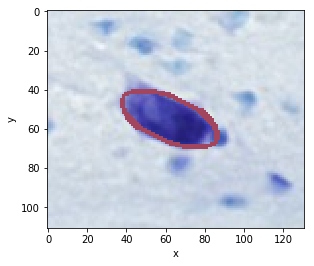

In [94]:
tempBID = 657
tempMargin = 40
tempImage = fun_crop_images(image[section],*im_blob_prop[section][tempBID]['bbox'],im0max=scan_parameters['im0max'],im1max=scan_parameters['im1max'],margin=tempMargin)
plt.imshow(tempImage)
plt.xlabel('x')
plt.ylabel('y')

local_pos = np.array(im_blob_prop[section][tempBID].local_centroid,dtype=np.int)[::-1]+tempMargin
# ellipse_angle = 180 - int(fun_angle_arc_to_degree(blob_prop_dic[curr_blob_section]['orientation'][tempBID]))
ellipse_angle = fun_angle_np_to_cv2(int(fun_angle_arc_to_degree(blob_prop_dic[curr_blob_section]['orientation'][tempBID])))
#     print(ellipse_angle)
# Draw ellipse
cell_contour = cv2.ellipse2Poly(tuple(local_pos),
            tuple([(0.5*blob_prop_dic[curr_blob_section]['major_axis_length'][tempBID]).astype(np.int),
                   (0.5*blob_prop_dic[curr_blob_section]['minor_axis_length'][tempBID]).astype(np.int)]),
           ellipse_angle,0,360,10)
cv2.polylines(tempImage, [cell_contour.astype(np.int32)], isClosed=True, color=map_color[curr_blob_id],thickness=2)

plt.imshow(tempImage)

In [53]:
fun_angle_arc_to_degree(im_blob_prop[section][657]['orientation'])

-23.23499656107896

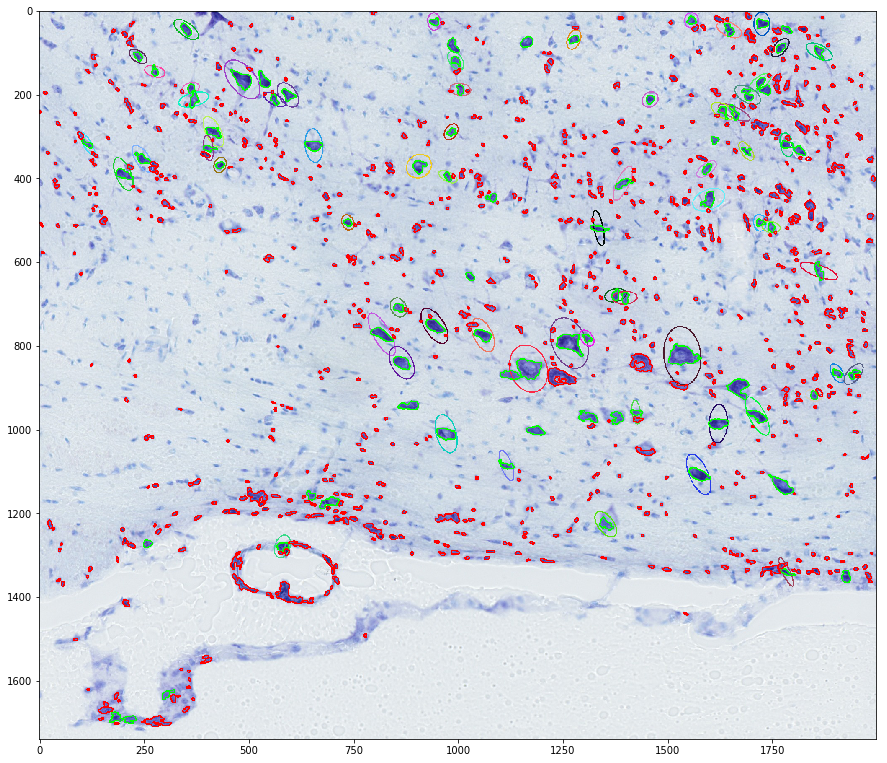

In [32]:
# + PI/2
plt.figure(figsize=(15,15))
plt.imshow(curr_fig_blob_vis[section])

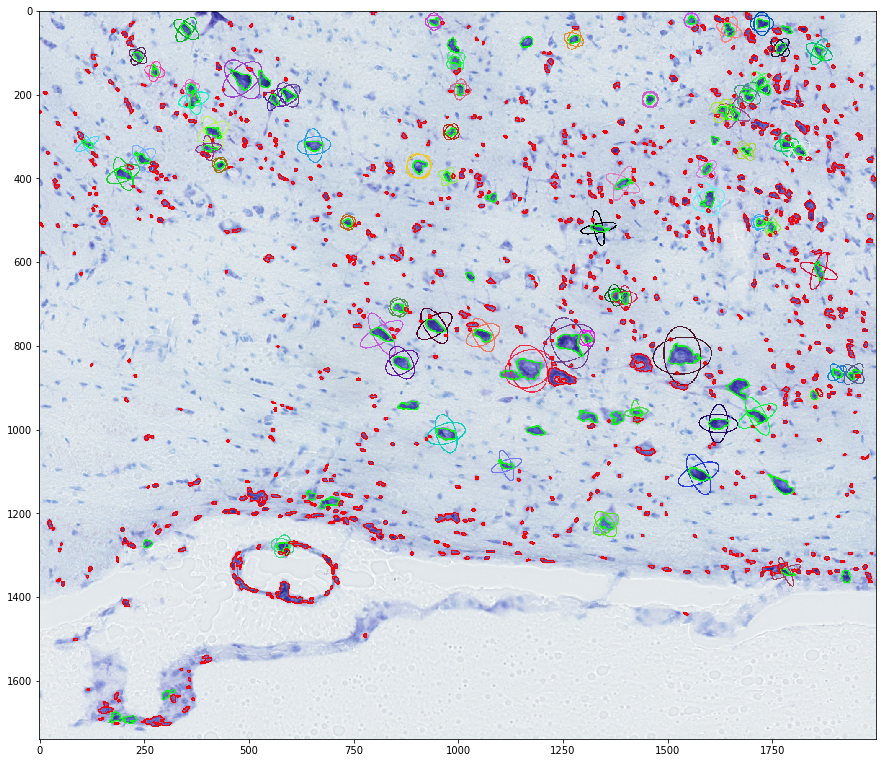

In [42]:
# + PI
plt.figure(figsize=(15,15))
plt.imshow(curr_fig_blob_vis[section])

In [162]:
display_image(matched_fig_blob_vis[152])

/shared/MouseBrainAtlasXiang/XJ/tmp.jpg

In [163]:
display_image(matched_fig_blob_vis[154])

/shared/MouseBrainAtlasXiang/XJ/tmp.jpg

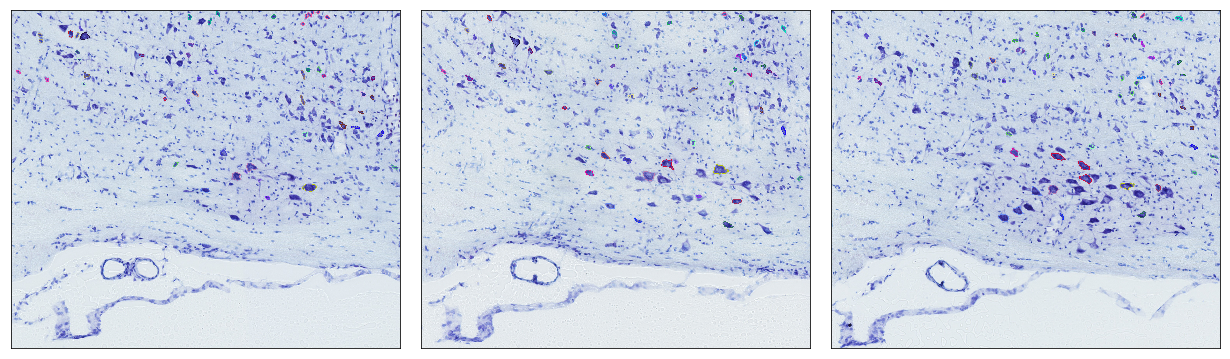

In [114]:
display_images_in_grids([matched_fig_blob_vis[152], curr_fig_blob_vis[section], matched_fig_blob_vis[154]],nc=3)